In [ ]:
%pip install underthesea
%pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.3/591.3 KB 33.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import joblib

In [ ]:
from underthesea import word_tokenize
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [ ]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.17" 2022-10-18
OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu218.04)
OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu218.04, mixed mode, sharing)


In [ ]:
!pip install vncorenlp
!pip install fastBPE
!pip install fairseq
!pip install tensorboard --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 36.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645950 sha256=26ad5d846c22c6af7f00fbec0ffd2e131b15b7ae4c8eb9ccd39a40e952cc97b9
  Stored in directory: /root/.cache/pip/wheels/3c/e9/86/706911c12e307aeb9a2702399f0dad38d36f1d6f9dde8af35e
Successfully built vncorenlp
ERROR: Operation cancelled by user
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
ERROR: Operation cancelled by user
ERROR: Operation cancelled by user
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 24.1 MB/s eta 0:00:00
ERROR: Operation cancelled by user
Traceback (most recent call l

# Tạo dataset & tiền xử lý dữ liệu

## 1. Giải nén file dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/CS221/

/content/drive/MyDrive/CS221


In [ ]:
import os 
os.listdir()

['PhoBERT_base_transformers',
 'PhoBERT_base_transformers.tar.gz',
 'UIT-VSMEC',
 'vncorenlp',
 'data_gui_bao.csv',
 'data.csv',
 'stopwords.txt',
 'runs',
 'data_aug.csv',
 'data_aug_N.csv',
 'data_aug2.csv',
 'test.csv',
 'data_aug1.csv',
 'confusion_matrix.png',
 'test_processed.csv',
 'pytorch_phoBERT_sentiment.bin',
 'test_preprocess.csv',
 'data_merged.csv']

## 2. Lấy danh sách các stopwords

In [ ]:
stopwords = []

with open('stopwords.txt', 'r+', encoding='utf-8') as f:
    for line in f:
        stopwords.append(line.strip())

print(len(stopwords))

1942


## 3. Định nghĩa các hàm hỗ trợ tiền xử lý dữ liệu

In [ ]:
import re

def strip_emoji(text):
	RE_EMOJI = re.compile(u'([\U00002600-\U000027BF])|([\U0001f300-\U0001f64F])|([\U0001f680-\U0001f6FF])')
	return RE_EMOJI.sub(r'', text)

def remove_special_char(text):
	special_character = re.compile("�+")
	return special_character.sub(r'', text)

def remove_punctuation(text):
	punctuation = re.compile(r"[!#$%&()*+;<=>?@[\]^_`{|}~]")
	return punctuation.sub(r"", text)

def remove_number(text):
	return re.sub(" \d+", " ", text)

def normalize_annotatation(text):
	khach_san = "\bkhach san ?|\bksan ?|\bks ?"
	return re.sub("\bnv ?", "nhân viên",re.sub(khach_san, "khách sạn", text))

def clean_text(text):
	return {"Review": normalize_annotatation(remove_number(remove_special_char(remove_punctuation(strip_emoji(text["Review"].lower())))))}


In [ ]:
# Tiền xử lý: loại bỏ các dấu , . ! ?,
# loại bỏ dấu cách thừa và chuyển string về dạng lowercase.

def preprocess(sentence):
    sentence = sentence.strip()
    sentence = sentence.replace(',', '')
    sentence = sentence.replace('.', '')
    sentence = sentence.replace('?', '')
    sentence = sentence.replace('!', '')
    sentence = sentence.replace('"', '')
    sentence = sentence.replace('  ', ' ')

    specials_ = {
        ':)' : 'colonsmile',
        ':(' : 'colonsad',
        '@@' : 'colonsurprise',
        '<3' : 'colonlove',
        ':d' : 'colonsmilesmile',
        ':3' : 'coloncontemn',
        ':v' : 'colonbigsmile',
        ':_' : 'coloncc',
        ':p' : 'colonsmallsmile',
        '>>' : 'coloncolon',
        ':">' : 'colonlovelove',
        '^^' : 'colonhihi',
        ':' : 'doubledot',
        ":'(" : 'colonsadcolon',
        ':’(' : 'colonsadcolon',
        ':@' : 'colondoublesurprise',
        'v.v' : 'vdotv',
        '...' : 'dotdotdot',
        '/' : 'fraction',
        'c#' : 'cshrap',
    }

    for key in specials_.keys():
        sentence = sentence.replace(key, specials_[key])
    return sentence.lower().strip()

## 4. Tạo dataset

Phần dataset train & test (tui list ra vầy mà Bảo cho tui cái 1, 2, 3, 4 là đc ròi, 5 vs 6 Bảo hông làm cũng đc):
1. show sample data (10 câu)
2. chart distribution thống kê class
3. sample 3 câu cho mỗi class
4. thống kê distrubution độ dài câu
5. sample câu min, max và câu vs 3 câu nằm trong nhóm freq từ phổ biến nhất
6. chồng 2 cái chart dis (để nói về correlation)

In [ ]:
#y 1
for i in range(10,20):
    # print(train_dataset.iloc[i]["label"])
    # print(train_dataset.iloc[i]["Review"])
    print("Review: ", train_dataset.iloc[i]["Review"])
    print("Label: ", train_dataset.iloc[i]["labels"])


Review:  Tuy không tiện nghi nhưng giá cả bình dân nhất Quy Nhơn
Label:  4
Review:  Giường hơi mềm, không phù hợp lắm với người bị đau lưng
Label:  3
Review:  Có thể do dịch nên ít khách. Phòng có mùi mốc
Label:  2
Review:  Cách âm kém, ko có hỗ trợ KH về các vật dụng mượn thêm vào buổi tối (như tô muỗng)
Label:  2
Review:  30/4 vừa rồi đông khách, vợ mình đợi 30" chưa đi được thang máy.
Label:  3
Review:  Có chỗ để xe máy ở tầng trệt, ở trong hẻm nhưng đường đủ rộng để xe 4 bánh vào tới nơi.
Label:  2
Review:  Phòng sạch sẽ gọn gàng, nhân viên nhiệt tình thân thiện và chu đáo.
Label:  5
Review:  Phòng khá cũ. Mình ở 2 lần 1 lần ở phòng bình thường thì thấy ok. 1 lần ở studio view biển thất vọng thực sự. View biển đã bị chắn bởi công trình (này thì không phải lỗi của khách sạn nhưng hơi bị trái so với kì vọng của mình). Phòng thì cực kì nóng nực. Lúc mới check in vô thì bật điều hoà đúng mode và nhiệt độ thấp nhưng vẫn cực kì nóng. Gọi nhân viên lễ tân thì bạn nói câu “biết sao không?”

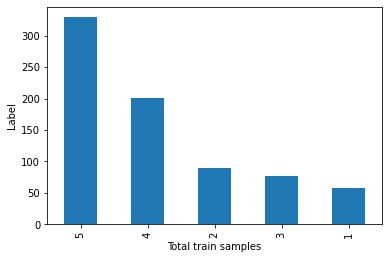

In [ ]:
#Dữ liệu trước khi tăng cường
train_dataset = pd.read_csv("data.csv")
count = train_dataset['labels'].value_counts()
count.plot.bar()
plt.ylabel('Label')
plt.xlabel('Total train samples')
plt.show()

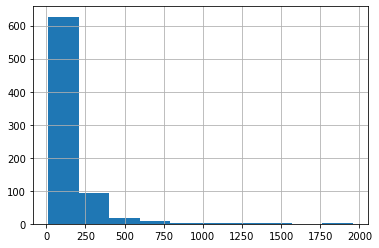

In [ ]:
train_dataset['Review'].str.len().hist()

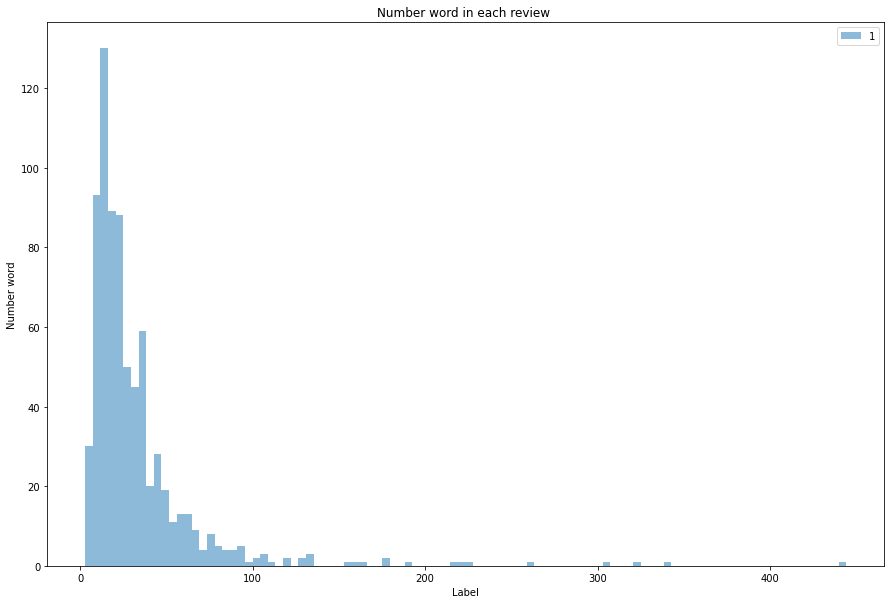

In [ ]:
train_dataset["word_count"] = train_dataset["Review"].apply(lambda x: len(str(x).split(" ")))
#visualize number word in each label
plt.figure(figsize=(15,10))
plt.title("Number word in each review ")
plt.xlabel("Label")
plt.ylabel("Number word")
plt.hist(train_dataset['word_count'],bins=100,alpha=0.5,label='1')
# plt.hist(train_dataset[train_dataset['labels']==2]['word_count'],bins=100,alpha=0.5,label='2')
# #plt.hist(train_dataset[train_dataset['labels']==3]['word_count'],bins=100,alpha=0.5,label='3')
# #plt.hist(train_dataset[train_dataset['labels']==4]['word_count'],bins=100,alpha=0.5,label='4')
# plt.hist(train_dataset[train_dataset['labels']==5]['word_count'],bins=100,alpha=0.5,label='5')
plt.legend(loc='upper right')
plt.show()

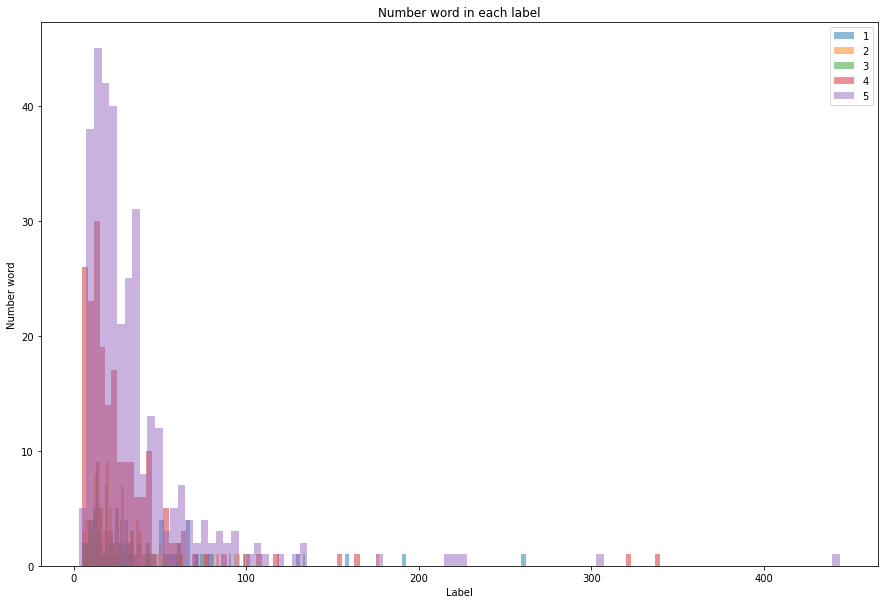

In [ ]:
train_dataset["word_count"] = train_dataset["Review"].apply(lambda x: len(str(x).split(" ")))
#visualize number word in each label
plt.figure(figsize=(15,10))
plt.title("Number word in each label")
plt.xlabel("Label")
plt.ylabel("Number word")
plt.hist(train_dataset[train_dataset['labels']==1]['word_count'],bins=100,alpha=0.5,label='1')
plt.hist(train_dataset[train_dataset['labels']==2]['word_count'],bins=100,alpha=0.5,label='2')
plt.hist(train_dataset[train_dataset['labels']==3]['word_count'],bins=100,alpha=0.5,label='3')
plt.hist(train_dataset[train_dataset['labels']==4]['word_count'],bins=100,alpha=0.5,label='4')
plt.hist(train_dataset[train_dataset['labels']==5]['word_count'],bins=100,alpha=0.5,label='5')
plt.legend(loc='upper right')
plt.show()

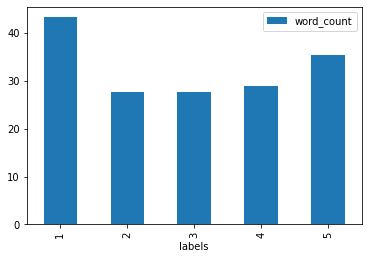

In [ ]:
train_dataset[['labels','word_count']].groupby(['labels']).mean().plot.bar()

In [ ]:
train_dataset[['labels','word_count']].groupby(['labels']).mean().plot.bar()

In [ ]:
labels_list=[1,2,3,4,5]
for label in labels_list:
    #print 3 samples for each label
    print("Label: ",label)
    df_label=train_dataset[train_dataset['labels']==label]
    #print review 3 sample 
    print(df_label['Review'].iloc[3])
    print(df_label['Review'].iloc[5])
    print(df_label['Review'].iloc[10])

Label:  1
Mình đã đặt 11 phòng cho kì nghỉ và rất thất vọng.
khách ở từ thứ 3 đến thứ 7, mà khách sạn không hề lau dọn phòng.
Thiếu nhiều vật dung cơ bản: khăn giấy trên phòng, bàn là hỏi nhân viên nhiều lần mới có do cả Ks có 1 bàn là duy nhất.
Label:  2
Khe vịn mở cửa tủ quần áo hơi cạn nên khi mở hơi khó, dễ gãy móng tay, nên khoét sâu hơn hoặc có nắm cửa bên ngoài.
Cách âm kém, đêm hôm phòng bên cạnh cười nghe rõ. Không có nhân viên hỗ trợ xách đồ. View biển nhưng trước mặt có công trình xây dựng
Vị trí gần biển nhưng do khách sạn nằm trong ngõ nên view biển căn góc không thực sự đẹp như trong hình
Label:  3
Cá nhân mình thấy phòng hơi thiếu sáng
Tiện nghi có một số hạn chế. Không có bàn ủi trong phòng, muốn ủi đồ phải thuê khách sạn. Đối với ks 4 sao thì tôi thấy đây là khuyết điểm
Máy lạnh Daikin nhưng điều khiển chỉ cho tắt mở và tăng giảm nhiệt chứ không điều chỉnh được chế độ quạt và làm lạnh.
Label:  4
Khách sạn gần trung tâm đi lại khá tiện. Phòng ốc xịn xò sạch sẽ. Mình boo

In [ ]:
near_avg=train_dataset[train_dataset['word_count']<35][train_dataset['word_count']>30]

<ipython-input-29-9d97a01ded0a>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  near_avg=train_dataset[train_dataset['word_count']<35][train_dataset['word_count']>30]


In [ ]:
near_avg[:5]#top 5 cau trung binh

,labels,Review,word_count
22,5,"Nhân viên phục vụ rất nhiệt tình, giá cả cũng ...",32
48,5,"Khách sạn mới, sạch sẽ, ở vị trí thuận lợi. Nh...",32
51,4,Từ nhân viên đến bạn quản lý ai đều rất thân t...,34
57,5,JW Marriott đa phần có dịch vụ tốt. Không phải...,31
81,5,"Dịch vụ ok.ql thân thiện , Nv phục vụ chuẩn k ...",32


In [ ]:
train_dataset['word_count'].mean()

32.626490066225166

In [ ]:
#top thap nhat va cao nhat
max_review=train_dataset[train_dataset['word_count']==train_dataset['word_count'].max()]
min_review=train_dataset[train_dataset['word_count']==train_dataset['word_count'].min()]

In [ ]:
max_review

,labels,Review,word_count
355,5,Theo mình thấy là giá khá cao so với các chỗ k...,444


In [ ]:
min_review

,labels,Review,word_count
631,5,Phòng sạch sẽ,3


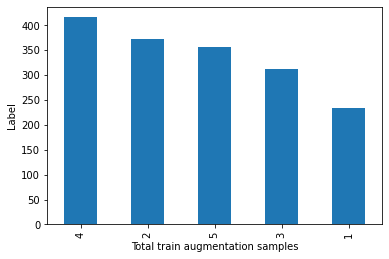

In [ ]:
train_dataset = pd.read_csv("data_merged.csv")
count = train_dataset['labels'].value_counts()
count.plot.bar()
plt.ylabel('Label')
plt.xlabel('Total train augmentation samples')
plt.show()

In [ ]:
print(len(train_dataset))

1691


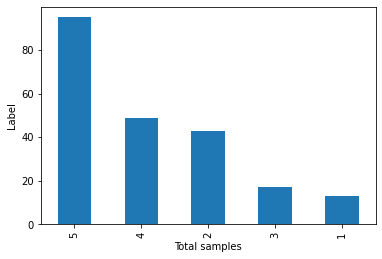

In [ ]:
test_dataset =  pd.read_csv("test.csv")
test_dataset['labels'].value_counts()
count = test_dataset['labels'].value_counts()
count.plot.bar()
plt.ylabel('Label')
plt.xlabel('Total samples')
plt.show()


# Data Preprocessing and Vectorize

In [ ]:
#emoji
text="5,Cái giường nó bị dính qá 😋 ngủ mà k tỉnh dc kkk"
print(text)

print(strip_emoji(text))

5,Cái giường nó bị dính qá 😋 ngủ mà k tỉnh dc kkk
5,Cái giường nó bị dính qá  ngủ mà k tỉnh dc kkk


In [ ]:
#remove_punctuation
text="Thoáng mát, sạch sẽ..phòng studio view đẹp (phòng trên tầng cao nữa thì đẹp :))). Đồ ăn hơi ít món nhưng ngon."
print(text)
print(preprocess(text))
print()

Thoáng mát, sạch sẽ..phòng studio view đẹp (phòng trên tầng cao nữa thì đẹp :))). Đồ ăn hơi ít món nhưng ngon.
thoáng mát sạch sẽphòng studio view đẹp (phòng trên tầng cao nữa thì đẹp colonsmile)) đồ ăn hơi ít món nhưng ngon


In [ ]:
text="Phòng gia đình nhưng bị tách thành 2 phòng ghép với 4 giường nên kg thích lắm với cùng 1 phòng"
print(text)
print(remove_number(text))

Phòng gia đình nhưng bị tách thành 2 phòng ghép với 4 giường nên kg thích lắm với cùng 1 phòng
Phòng gia đình nhưng bị tách thành  phòng ghép với  giường nên kg thích lắm với cùng  phòng


In [ ]:
text="Chấm 10đ cho Fleur Hotel Quy Nhơn* Ưu điểm: ks đẹp, đối diện biển, buffet sáng ngon, nhân viên vô cùng ưng ý, thân thiện. Đặc biệt chị lễ tân Minh Hiếu rất đáng yêu.* Điểm trừ nhỏ là cách âm phòng kém quá:("
print(normalize_annotatation(text))

Chấm 10đ cho Fleur Hotel Quy Nhơn* Ưu điểm: khách sạn đẹp, đối diện biển, buffet sáng ngon, nhân viên vô cùng ưng ý, thân thiện. Đặc biệt chị lễ tân Minh Hiếu rất đáng yêu.* Điểm trừ nhỏ là cách âm phòng kém quá:(


In [ ]:
#remove stopword
remove_VN_stopwords("Phòng gia đình nhưng bị tách thành 2 phòng ghép với 4 giường nên kg thích lắm với cùng 1 phòng")

'Phòng gia đình tách thành 2 phòng ghép 4 giường kg lắm 1 phòn'

In [ ]:
text="Chấm 10đ cho Fleur Hotel Quy Nhơn* Ưu điểm: ks đẹp, đối diện biển, buffet sáng ngon, nhân viên vô cùng ưng ý, thân thiện. Đặc biệt chị lễ tân Minh Hiếu rất đáng yêu.* Điểm trừ nhỏ là cách âm phòng kém quá:("
print(clean_text(text))

chấm 10đ cho fleur hotel quy nhơn ưu điểm: khách sạn đẹp, đối diện biển, buffet sáng ngon, nhân viên vô cùng ưng ý, thân thiện. đặc biệt chị lễ tân minh hiếu rất đáng yêu. điểm trừ nhỏ là cách âm phòng kém quá:


In [ ]:
print(normalize_annotatation(text))

Chấm 10đ cho Fleur Hotel Quy Nhơn* Ưu điểm: ks đẹp, đối diện biển, buffet sáng ngon, nhân viên vô cùng ưng ý, thân thiện. Đặc biệt chị lễ tân Minh Hiếu rất đáng yêu.* Điểm trừ nhỏ là cách âm phòng kém quá:(


In [ ]:
text="Phòng sạch sẽ, thơm, chị lao công cũng dễ thương hoà đồng. Cô chú chủ cực kỳ cute luôn á mọi người. View phòng đẹp, xung quanh yên tĩnh. Mọi người nên ghé nhaaaa."
print(text)
text=remove_similarletter(text)
print(text)

Phòng sạch sẽ, thơm, chị lao công cũng dễ thương hoà đồng. Cô chú chủ cực kỳ cute luôn á mọi người. View phòng đẹp, xung quanh yên tĩnh. Mọi người nên ghé nhaaaa.
Phòng sạch sẽ, thơm, chị lao công cũng dễ thương hoà đồng. Cô chú chủ cực kỳ cute luôn á mọi người. View phòng đẹp, xung quanh yên tĩnh. Mọi người nên ghé nha.


In [ ]:
# Bỏ bớt các chữ cái giống nhau liên tiếp( Vd: quaaa -> qua)
def remove_similarletter(text):
    text = re.sub(r'([a-z])\1+', lambda m: m.group(1).lower(), text, flags=re.IGNORECASE)
    return text
def strip_emoji(text):
	emoji_pattern = re.compile("["
					u"\U0001F600-\U0001F64F" 
					u"\U0001F300-\U0001F5FF"  
					u"\U0001F680-\U0001F6FF"  
					u"\U0001F1E0-\U0001F1FF"  
					u"\U00002702-\U000027B0"
					u"\U000024C2-\U0001F251"
					"]+", flags=re.UNICODE)	
	return emoji_pattern.sub(r'', text)

def remove_special_char(text):
	special_character = re.compile("�+")
	return special_character.sub(r'', text)

def remove_punctuation(text):
	punctuation = re.compile(r"[!#$%&()*+;<=>?@[\]^_`{|}~]")
	return punctuation.sub(r"", text)

def remove_number(text):
	return re.sub(" \d+", " ", text)

def normalize_annotatation(text):
	replace_list = {
		'ship': 'vận chuyển', 'shop': 'cửa hàng', 'sho': 'cửa hàng', 'm': 'mình','mk':'mình','mjk':'mình', 'mik': 'mình', 'ko': 'không' , 'k': 'không', 'kh': 'không', 'khong': 'không', 'kg': 'không', 'khg': 'không','hok':'không','hong':'không', 'tl': 'trả lời',
		'rep': 'trả lời', 'r': 'rồi', 'fb': 'facebook', 'face': 'faceook', 'thanks': 'cảm ơn', 'thank': 'cảm ơn', 'tks': 'cảm ơn', 'tk': 'cảm ơn', 'ok': 'tốt', 'oki': 'tốt', 'okie': 'tốt', 'sp': 'sản phẩm',
		'dc': 'được','đc':'được','dk':'được', 'vs': 'với', 'đt': 'điện thoại', 'thjk': 'thích', 'thik': 'thích', 'qá': 'quá', 'trể': 'trễ', 'bgjo': 'bao giờ', 'h': 'giờ', 'qa': 'quá', 'dep': 'đẹp', 'xau': 'xấu', 'ib': 'nhắn tin',
		'cute': 'dễ thương', 'sz': 'size', 'good': 'tốt', 'god': 'tốt', 'bt': 'bình thường','tr':'triệu','dag':'đang','nhiu':'nhiêu','mn':'mọi người','m.n':'mọi người','ac':'anh chị','sag':'sang','s':'sao',
		'sz': 'cỡ', 'size': 'cỡ', 'đx': 'được', 'dk': 'được', 'dc': 'được', 'đk': 'được','ae':'anh em','j':'gì','hnay':'hôm nay','lm':'làm','ktra':'kiểm tra','sp':'sản phẩm','zô':'vào',
		'đc': 'được', 'authentic': 'chuẩn chính hãng', 'aut': 'chuẩn chính hãng', 'auth ': 'chuẩn chính hãng', 'thick': 'thích','v':'vậy','cng':'cũng','cg':'cũng','ns':'nói','nv':'nhân viên',
		'gud': 'tốt', 'god': 'tốt', 'wel done': 'tốt', 'good': 'tốt', 'gút': 'tốt','ng':'người','chs':'chơi','mng':'mọi người','wa':'quá',
		'sấu': 'xấu', 'gut': 'tốt', 'tot': 'tốt', 'nice': 'tốt', 'perfect': 'rất tốt','trc':'trước',
		'time': 'thời gian', 'qá': 'quá','nc':'nói chung','ace':'anh chị em',
		'product': 'sản phẩm', 'quality': 'chất lượng', 'chat': 'chất' , 'excelent': 'hoàn hảo', 'bad': 'tệ', 'sad': 'tệ',
		'beautiful': 'đẹp', 'tl': 'trả lời', 'r': 'rồi', 'order': 'đặt hàng',
		'chất lg': 'chất lượng', 'sd': 'sử dụng', 'dt': 'điện thoại', 'nt': 'nhắn tin', 'tl': 'trả lời', 'sài': 'xài', 'bjo': 'bao giờ',
		'thik': 'thích', 'sop': 'cửa hàng', 'fb': 'facebook', 'face': 'facebook', 'very': 'rất',
		'dep': 'đẹp', 'xau': 'xấu','tgdđ':'thế giới di động','tgdd':'thế giới di động','đmx':'điện máy xanh',
		'iu': 'yêu', 'fake': 'giả mạo', 'trl': 'trả lời', '><': 'tiêu cực',
		'por': 'tệ', 'poor': 'tệ', 'ib': 'nhắn tin', 'rep': 'trả lời', 'fback': 'feedback', 'fedback': 'feedback',
		'bin': 'pin', 'cx': 'cũng', 'nch': 'nói chuyện', 'ntn': 'như thế nào', 'vde': 'vấn đề',"tv":"tivi","ks":"khách sạn","nv":"nhân viên","KS":"khách sạn","kg":"không"
	}
	text = text.split()
	len_ = len(text)
	for i in range(0, len_):    
		for k, v in replace_list.items():
			if (text[i]==k):
				text[i] = v
	return " ".join(text)

def clean_text(text):
	return normalize_annotatation((remove_special_char(remove_punctuation(strip_emoji(text.lower())))))
 
def preprocess(sentence):
    sentence = sentence.strip()
    sentence = sentence.replace(',', '')
    sentence = sentence.replace('.', '')
    sentence = sentence.replace('?', '')
    sentence = sentence.replace('!', '')
    sentence = sentence.replace('"', '')
    sentence = sentence.replace('  ', ' ')

    specials_ = {
        ':)' : 'colonsmile',
        ':(' : 'colonsad',
        '@@' : 'colonsurprise',
        '<3' : 'colonlove',
        ':d' : 'colonsmilesmile',
        ':3' : 'coloncontemn',
        ':v' : 'colonbigsmile',
        ':_' : 'coloncc',
        ':p' : 'colonsmallsmile',
        '>>' : 'coloncolon',
        ':">' : 'colonlovelove',
        '^^' : 'colonhihi',
        ':' : 'doubledot',
        ":'(" : 'colonsadcolon',
        ':’(' : 'colonsadcolon',
        ':@' : 'colondoublesurprise',
        'v.v' : 'vdotv',
        '...' : 'dotdotdot',
        '/' : 'fraction',
        'c#' : 'cshrap',
    }

    for key in specials_.keys():
        sentence = sentence.replace(key, specials_[key])
    return sentence.lower().strip()

In [ ]:
print(tokenize("Đại học Công Nghệ Thông Tin, đại học quốc gia Hồ Chí Minh."))

['Đại học', 'Công Nghệ', 'Thông Tin', ',', 'đại học', 'quốc gia', 'Hồ Chí Minh', '.']


In [ ]:
print(tokenize_VNCore("Đại học Công Nghệ Thông Tin, đại học quốc gia Hồ Chí Minh."))

[['Đại_học', 'Công_Nghệ_Thông_Tin', ',', 'đại_học', 'quốc_gia', 'Hồ_Chí_Minh', '.']]


In [ ]:
from collections import defaultdict
import unicodedata as ud
import pandas as pd
import numpy as np
import math
import ast
import re

In [ ]:
def syllablize(sentence):
    word = '\w+'
    non_word = '[^\w\s]'
    digits = '\d+([\.,_]\d+)+'
    
    patterns = []
    patterns.extend([word, non_word, digits])
    patterns = f"({'|'.join(patterns)})"
    
    sentence = ud.normalize('NFC', sentence)
    tokens = re.findall(patterns, sentence, re.UNICODE)
    return [token[0] for token in tokens]
def load_n_grams(path):
    with open(path, encoding='utf8') as f:
        words = f.read()
        words = ast.literal_eval(words)
    return words

In [ ]:
def longest_matching(sentence, bi_grams, tri_grams):
    syllables = syllablize(sentence)
    syl_len = len(syllables)
    
    curr_id = 0
    word_list = []
    done = False
    
    while (curr_id < syl_len) and (not done):
        curr_word = syllables[curr_id]
        if curr_id >= syl_len - 1:
            word_list.append(curr_word)
            done = True
        else:
            next_word = syllables[curr_id + 1]
            pair_word = ' '.join([curr_word.lower(), next_word.lower()])
            if curr_id >= (syl_len - 2):
                if pair_word in bi_grams:
                    word_list.append('_'.join([curr_word, next_word]))
                    curr_id += 2
                else:
                    word_list.append(curr_word)
                    curr_id += 1
            else:
                next_next_word = syllables[curr_id + 2]
                triple_word = ' '.join([pair_word, next_next_word.lower()])
                if triple_word in tri_grams:
                    word_list.append('_'.join([curr_word, next_word, next_next_word]))
                    curr_id += 3
                elif pair_word in bi_grams:
                    word_list.append('_'.join([curr_word, next_word]))
                    curr_id += 2
                else:
                    word_list.append(curr_word)
                    curr_id += 1
    return word_list

In [ ]:
bi_grams = load_n_grams('bi_grams.txt')
tri_grams = load_n_grams('tri_grams.txt')
longest_matching('Mình hay ghé nhà hàng Ngon ở Trần Hưng Đạo để dùng bữa với bạn bè và đối tác.', bi_grams, tri_grams)

['Mình',
 'hay',
 'ghé',
 'nhà_hàng',
 'Ngon',
 'ở_Trần',
 'Hưng',
 'Đạo',
 'để',
 'dùng_bữa',
 'với',
 'bạn_bè',
 'và',
 'đối_tác',
 '.']

In [ ]:
# Hàm tách từ, dùng word_tokenize của underthesea
def tokenize(sentence):
    return word_tokenize(sentence, format = 'word')
def tokenize_VNCore(sentence):
    return rdrsegmenter.tokenize(sentence)[0]
def tokenize_longest_matching(sentence):
    return longest_matching(sentence, bi_grams, tri_grams)
# Chuyển câu tiếng Việt về vector, sử dụng CountVectorizer của sklearn
# với các tham số là danh sách stopwords tiếng Việt 
# và tokenizer tách từ tiếng Việt
vectorizer = CountVectorizer(
    stop_words = stopwords,
    tokenizer = tokenize
)
vectorizer_vncore = CountVectorizer(
    stop_words = stopwords,
    tokenizer = tokenize_VNCore
)
vectorizer_longestmatching=CountVectorizer(
    stop_words = stopwords,
    tokenizer =tokenize_longest_matching
)

In [ ]:
# Test import
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("/content/drive/MyDrive/CS221/vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 

text = "Đại học Công Nghệ Thông Tin, đại học quốc gia Hồ Chí Minh."

word_segmented_text = rdrsegmenter.tokenize(text) 
print(word_segmented_text)

[['Đại_học', 'Công_Nghệ_Thông_Tin', ',', 'đại_học', 'quốc_gia', 'Hồ_Chí_Minh', '.']]


In [ ]:
def load_data(df):
    X=df["Review"]
    y=df["labels"]
    X=X.apply(preprocess)
    X=X.apply(clean_text)
    return X,y

In [ ]:
X,y=load_data(pd.read_csv("data.csv"))
X_test,y_test=load_data(pd.read_csv("test.csv")) 

In [ ]:
X,y=load_data(pd.read_csv("data_merged.csv"))
X_test,y_test=load_data(pd.read_csv("test.csv")) 

In [ ]:
#su dung count vector
X= vectorizer_vncore.fit_transform(X)
X_test=vectorizer_vncore.transform(X_test)

In [ ]:
#su dung count vector
X= vectorizer_longestmatching.fit_transform(X)
X_test=vectorizer_longestmatching.transform(X_test)

In [ ]:
#su dung count vector
X= vectorizer.fit_transform(X)
X_test=vectorizer.transform(X_test)

In [ ]:
file_stopwords = pd.read_csv("stopwords.txt", encoding = 'UTF-8')
file_stopwords.columns = ["Stop_words"]
VN_stopword = []
for i in file_stopwords["Stop_words"]:
    VN_stopword.append(i)

In [ ]:
def remove_VN_stopwords(text):
    text_token = tokenize(text)
    result = [word for word in text_token if word not in VN_stopword]
    return " ".join(result)

In [ ]:
#su dung tfidf 
from sklearn.feature_extraction.text import TfidfVectorizer
X=X.apply(remove_VN_stopwords)
X_test=X_test.apply(remove_VN_stopwords)
# Chuyển câu tiếng Việt về vector, sử dụng TfidfVectorizer của sklearn

tf_idf = TfidfVectorizer()
X= tf_idf.fit_transform(X)
X_test=tf_idf.transform(X_test)

# Training model

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

## Naive Bayes

In [ ]:
#sử dụng untherthesea +count vectorize
model = MultinomialNB()
model.fit(X, y)
y_pred=model.predict(X_test)
print("Accuracy: ", model.score(X_test, y_test))
print("F1 score: ", f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))


Accuracy:  0.5714285714285714
F1 score:  0.4530140776243596
              precision    recall  f1-score   support

           1       0.53      0.62      0.57        13
           2       0.79      0.44      0.57        43
           3       0.33      0.18      0.23        17
           4       0.29      0.12      0.17        49
           5       0.59      0.93      0.72        95

    accuracy                           0.57       217
   macro avg       0.51      0.46      0.45       217
weighted avg       0.54      0.57      0.52       217



In [ ]:
#sử dụng tf-idf
model = MultinomialNB()
model.fit(X, y)
y_pred=model.predict(X_test)
print("Accuracy: ", model.score(X_test, y_test))
print("F1 score: ", f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))


Accuracy:  0.4700460829493088
F1 score:  0.20478367734006833
              precision    recall  f1-score   support

           1       1.00      0.08      0.14        13
           2       0.83      0.12      0.20        43
           3       0.00      0.00      0.00        17
           4       0.12      0.02      0.04        49
           5       0.47      1.00      0.64        95

    accuracy                           0.47       217
   macro avg       0.49      0.24      0.20       217
weighted avg       0.46      0.47      0.34       217



In [ ]:
#sử dụng Augmentation
model = MultinomialNB()
model.fit(X, y)
y_pred=model.predict(X_test)
print("Accuracy: ", model.score(X_test, y_test))
print("F1 score: ", f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))


Accuracy:  0.6175115207373272
F1 score:  0.5549164935640345
              precision    recall  f1-score   support

           1       0.47      0.69      0.56        13
           2       0.74      0.58      0.65        43
           3       0.30      0.35      0.32        17
           4       0.46      0.53      0.50        49
           5       0.77      0.72      0.74        95

    accuracy                           0.62       217
   macro avg       0.55      0.57      0.55       217
weighted avg       0.64      0.62      0.62       217



In [ ]:
#sử dụng VNCore
model = MultinomialNB()
model.fit(X, y)
y_pred=model.predict(X_test)
print("Accuracy: ", model.score(X_test, y_test))
print("F1 score: ", f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))


Accuracy:  0.5990783410138248
F1 score:  0.5478388278388279
              precision    recall  f1-score   support

           1       0.53      0.69      0.60        13
           2       0.71      0.58      0.64        43
           3       0.27      0.35      0.31        17
           4       0.45      0.51      0.48        49
           5       0.75      0.68      0.71        95

    accuracy                           0.60       217
   macro avg       0.54      0.56      0.55       217
weighted avg       0.62      0.60      0.61       217



In [ ]:
#sử dụng maxixum matching
model = MultinomialNB()
model.fit(X, y)
y_pred=model.predict(X_test)
print("Accuracy: ", model.score(X_test, y_test))
print("F1 score: ", f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))


Accuracy:  0.543778801843318
F1 score:  0.42719561732219963
              precision    recall  f1-score   support

           1       0.47      0.54      0.50        13
           2       0.77      0.40      0.52        43
           3       0.30      0.18      0.22        17
           4       0.25      0.14      0.18        49
           5       0.59      0.88      0.71        95

    accuracy                           0.54       217
   macro avg       0.48      0.43      0.43       217
weighted avg       0.52      0.54      0.50       217



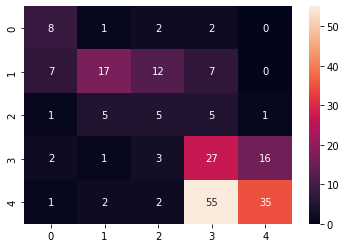

In [ ]:
vis=sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
plt.savefig('confusion_matrix.png')

## SVM

In [ ]:
model=SVC()
model.fit(X, y)

#f1 score
from sklearn.metrics import f1_score
y_pred=model.predict(X_test)
print("Accuracy: ", model.score(X_test, y_test))
print("F1 score: ", f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))

Accuracy:  0.5069124423963134
F1 score:  0.36123881572689426
              precision    recall  f1-score   support

           1       0.80      0.31      0.44        13
           2       0.83      0.23      0.36        43
           3       0.25      0.06      0.10        17
           4       0.23      0.20      0.22        49
           5       0.56      0.89      0.69        95

    accuracy                           0.51       217
   macro avg       0.53      0.34      0.36       217
weighted avg       0.53      0.51      0.46       217



In [ ]:
model=SVC(kernel="rbf")
model.fit(X, y)

#f1 score
from sklearn.metrics import f1_score
y_pred=model.predict(X_test)
print("Accuracy: ", model.score(X_test, y_test))
print("F1 score: ", f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))

Accuracy:  0.5668202764976958
F1 score:  0.4443105581217348
              precision    recall  f1-score   support

           1       0.71      0.38      0.50        13
           2       0.83      0.47      0.60        43
           3       0.43      0.18      0.25        17
           4       0.38      0.12      0.18        49
           5       0.55      0.94      0.69        95

    accuracy                           0.57       217
   macro avg       0.58      0.42      0.44       217
weighted avg       0.57      0.57      0.51       217



In [ ]:
model=SVC()
model.fit(X, y)

#f1 score
from sklearn.metrics import f1_score
y_pred=model.predict(X_test)
print("Accuracy: ", model.score(X_test, y_test))
print("F1 score: ", f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))

Accuracy:  0.6359447004608295
F1 score:  0.5936548850131194
              precision    recall  f1-score   support

           1       0.73      0.62      0.67        13
           2       0.71      0.74      0.73        43
           3       0.36      0.29      0.32        17
           4       0.46      0.67      0.55        49
           5       0.79      0.63      0.70        95

    accuracy                           0.64       217
   macro avg       0.61      0.59      0.59       217
weighted avg       0.66      0.64      0.64       217



In [ ]:
model=SVC()
model.fit(X, y)

#f1 score
from sklearn.metrics import f1_score
y_pred=model.predict(X_test)
print("Accuracy: ", model.score(X_test, y_test))
print("F1 score: ", f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))

Accuracy:  0.6175115207373272
F1 score:  0.5702299379349908
              precision    recall  f1-score   support

           1       0.62      0.62      0.62        13
           2       0.67      0.72      0.70        43
           3       0.31      0.29      0.30        17
           4       0.45      0.67      0.54        49
           5       0.83      0.60      0.70        95

    accuracy                           0.62       217
   macro avg       0.58      0.58      0.57       217
weighted avg       0.66      0.62      0.63       217



In [ ]:
model=SVC()
model.fit(X, y)

#f1 score
from sklearn.metrics import f1_score
y_pred=model.predict(X_test)
print("Accuracy: ", model.score(X_test, y_test))
print("F1 score: ", f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))

Accuracy:  0.5253456221198156
F1 score:  0.408270762868464
              precision    recall  f1-score   support

           1       0.80      0.31      0.44        13
           2       0.80      0.28      0.41        43
           3       0.43      0.18      0.25        17
           4       0.26      0.22      0.24        49
           5       0.57      0.88      0.69        95

    accuracy                           0.53       217
   macro avg       0.57      0.37      0.41       217
weighted avg       0.55      0.53      0.49       217



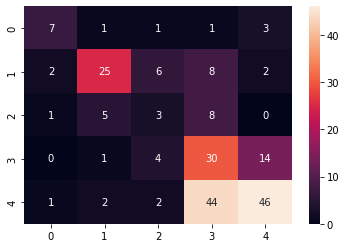

In [ ]:
vis=sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
plt.savefig('confusion_matrix.png')

## Random Forest

In [ ]:
model=RandomForestClassifier()
model.fit(X, y)
y_pred=model.predict(X_test)
print("Accuracy: ", model.score(X_test, y_test))
print("F1 score: ", f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))

Accuracy:  0.5253456221198156
F1 score:  0.4451240306174107
              precision    recall  f1-score   support

           1       0.60      0.46      0.52        13
           2       0.77      0.40      0.52        43
           3       0.25      0.18      0.21        17
           4       0.27      0.31      0.29        49
           5       0.62      0.77      0.69        95

    accuracy                           0.53       217
   macro avg       0.50      0.42      0.45       217
weighted avg       0.54      0.53      0.52       217



In [ ]:
model=RandomForestClassifier()
model.fit(X, y)
y_pred=model.predict(X_test)
print("Accuracy: ", model.score(X_test, y_test))
print("F1 score: ", f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))

Accuracy:  0.5161290322580645
F1 score:  0.42722851694848474
              precision    recall  f1-score   support

           1       0.60      0.46      0.52        13
           2       0.79      0.35      0.48        43
           3       0.23      0.18      0.20        17
           4       0.30      0.24      0.27        49
           5       0.56      0.80      0.66        95

    accuracy                           0.52       217
   macro avg       0.50      0.41      0.43       217
weighted avg       0.52      0.52      0.49       217



In [ ]:
model=RandomForestClassifier()
model.fit(X, y)
y_pred=model.predict(X_test)
print("Accuracy: ", model.score(X_test, y_test))
print("F1 score: ", f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))

Accuracy:  0.6497695852534562
F1 score:  0.6161701802912307
              precision    recall  f1-score   support

           1       0.62      0.77      0.69        13
           2       0.79      0.60      0.68        43
           3       0.55      0.35      0.43        17
           4       0.45      0.67      0.54        49
           5       0.79      0.69      0.74        95

    accuracy                           0.65       217
   macro avg       0.64      0.62      0.62       217
weighted avg       0.68      0.65      0.66       217



In [ ]:
model=RandomForestClassifier()
model.fit(X, y)
y_pred=model.predict(X_test)
print("Accuracy: ", model.score(X_test, y_test))
print("F1 score: ", f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))

Accuracy:  0.6405529953917051
F1 score:  0.5902938088157573
              precision    recall  f1-score   support

           1       0.60      0.69      0.64        13
           2       0.74      0.60      0.67        43
           3       0.35      0.35      0.35        17
           4       0.48      0.63      0.55        49
           5       0.78      0.71      0.74        95

    accuracy                           0.64       217
   macro avg       0.59      0.60      0.59       217
weighted avg       0.66      0.64      0.65       217



In [ ]:
model=RandomForestClassifier()
model.fit(X, y)
y_pred=model.predict(X_test)
print("Accuracy: ", model.score(X_test, y_test))
print("F1 score: ", f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))

Accuracy:  0.511520737327189
F1 score:  0.4423698041089345
              precision    recall  f1-score   support

           1       0.60      0.46      0.52        13
           2       0.76      0.37      0.50        43
           3       0.22      0.24      0.23        17
           4       0.27      0.31      0.29        49
           5       0.62      0.74      0.67        95

    accuracy                           0.51       217
   macro avg       0.50      0.42      0.44       217
weighted avg       0.54      0.51      0.51       217



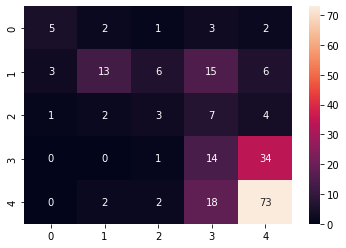

In [ ]:
vis=sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
plt.savefig('confusion_matrix.png')

# Data Augmentation 

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 79.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 16.5 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer,AutoModelWithLMHead
from transformers import pipeline, AutoModelWithLMHead, AutoTokenizer
from underthesea import word_tokenize
import random
import pandas as pd
from underthesea import pos_tag
phobert = AutoModel.from_pretrained("vinai/phobert-base")
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
model_ = AutoModelWithLMHead.from_pretrained("vinai/phobert-base")
nlp = pipeline("fill-mask", model=model_,tokenizer=tokenizer)



Downloading:   0%|          | 0.00/557 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/895k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.8/dist-packages/transformers/models/auto/modeling_auto.py:1177: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


In [ ]:

def augment(text,num_sent):
    tagging=pos_tag(text)
    word_token=word_tokenize(text)
    index_n=[]
    for i in range(len(tagging)):
        if tagging[i][1]=='N':
            index_n.append(i)
    list_aug=[]
    list_score=[]
    print(index_n)
    for index in index_n:
        word_token_copy=word_token.copy()
        word_token_copy[index]='<mask>'
        text=' '.join(word_token_copy)
        new_text_list=nlp(text)
        score=[i['score'] for i in new_text_list]
        new_text_list=[i['sequence'] for i in new_text_list ]
        list_score+=score
        list_aug+=new_text_list
    dict_score={i:j for i,j in zip(list_aug,list_score)}
    return dict_score 
    # list_aug=sorted(dict_score.items(), key=lambda x: x[1],reverse=True)
    # list_aug=[i[0] for i in list_aug]
    # list_aug=[i for i in list_aug if i!=text][:3]
    # return list_aug[:3]
aug=(augment('Khe vịn mở cửa tủ quần áo hơi cạn nên khi mở hơi khó, dễ gãy móng tay, nên khoét sâu hơn hoặc có nắm cửa bên ngoài.',3))

[3, 4, 8, 15, 16, 25, 26, 27]


In [ ]:
print(aug)

{'Khe vịn mở cửa mặc quần áo hơi cạn nên khi mở hơi khó, dễ gãy móng tay, nên khoét sâu hơn hoặc có nắm cửa bên ngoài.': 0.12839145958423615, 'Khe vịn mở cửa sau quần áo hơi cạn nên khi mở hơi khó, dễ gãy móng tay, nên khoét sâu hơn hoặc có nắm cửa bên ngoài.': 0.12647907435894012, 'Khe vịn mở cửa của quần áo hơi cạn nên khi mở hơi khó, dễ gãy móng tay, nên khoét sâu hơn hoặc có nắm cửa bên ngoài.': 0.07465775310993195, 'Khe vịn mở cửa ở quần áo hơi cạn nên khi mở hơi khó, dễ gãy móng tay, nên khoét sâu hơn hoặc có nắm cửa bên ngoài.': 0.051124487072229385, 'Khe vịn mở cửa bằng quần áo hơi cạn nên khi mở hơi khó, dễ gãy móng tay, nên khoét sâu hơn hoặc có nắm cửa bên ngoài.': 0.045155514031648636, 'Khe vịn mở cửa tủ thường hơi cạn nên khi mở hơi khó, dễ gãy móng tay, nên khoét sâu hơn hoặc có nắm cửa bên ngoài.': 0.13574711978435516, 'Khe vịn mở cửa tủ quần_áo hơi cạn nên khi mở hơi khó, dễ gãy móng tay, nên khoét sâu hơn hoặc có nắm cửa bên ngoài.': 0.13428083062171936, 'Khe vịn mở cử

In [ ]:
df=pd.read_csv("data.csv")
new_df=pd.DataFrame(columns=['Review','labels'])
review_list=[]
labels_list=[]
for i in range(len(df)):
    review=df['Review'][i]
    label=df['labels'][i]
    review_list=review_list+[review]
    labels_list=labels_list+[label]
    #print(review)
    try:
        aug=augment(review,3)
        review_list+=aug
        labels_list=labels_list+[label]*aug
        print(len(review_list))
        print(len(labels_list))
    except:
        continue
new_df['Review']=review_list
new_df['labels']=labels_list
new_df.to_csv("data_aug.csv",index=False)

[0, 2, 5, 10, 12, 14, 16, 18, 22, 23, 25, 34, 35, 38]
[1, 4, 7]
[0, 1, 3, 5, 7, 8, 11]
[0, 3, 6, 8, 10, 13, 17, 20, 21, 25, 27, 29, 31, 35, 37, 40, 43, 47, 51]
[0, 7, 9, 17]
[5, 9, 11, 12, 16, 24, 31]
[0, 9]
[0, 6, 13]
[0, 1, 5, 9, 14, 17, 18, 21, 24, 26, 30, 34, 37, 39, 43, 53]
[0, 3, 6, 7, 8, 16, 21, 23, 28, 31, 33, 38, 41, 42, 50, 52, 53, 57, 59, 62, 73]
[4]
[0, 8, 11]
[5, 8]
[0, 3, 9, 13, 14, 17, 18]
[0, 3, 5]
[1, 3, 5, 10, 12, 16, 18, 20]
[0, 4, 5]
[0, 6, 8, 10, 17, 19, 20, 21, 24, 25, 30, 36, 38, 45, 54, 63, 65, 72, 73, 75, 77, 88, 91, 92, 93, 95, 102, 107, 111, 112, 115, 120, 125, 127, 139, 140]
[0, 2, 7, 9, 11, 14, 19]
[0, 1, 5]
[3, 4, 8, 15, 16, 25, 26, 27]
[2, 3, 12, 13]
[0, 5, 7, 11, 13, 15, 19, 23]
[2, 4, 6, 12, 13, 15, 19, 26]
[0, 5, 11, 13, 20, 24, 26, 34]
[0, 1, 3, 7, 14, 15, 20, 21, 28, 31, 32, 34, 42, 44, 45, 47, 48, 52, 55]
[0, 4, 6]
[0, 3, 4, 5, 6, 7, 11, 13, 16, 17, 18, 21, 23]
[0, 1, 3, 4]
[2]
[0, 7, 9, 10, 11, 14, 15, 17]
[0, 1, 4, 6, 15, 16, 20, 22, 24, 29, 31, 3

Token indices sequence length is longer than the specified maximum sequence length for this model (435 > 256). Running this sequence through the model will result in indexing errors


[0, 7, 9, 15, 20, 27, 29, 39, 43, 47, 53, 56, 58, 60, 67, 78, 83, 85, 96, 104, 107, 108, 114, 118, 121, 124, 127, 132, 145, 148, 149, 151, 152, 154, 156, 157, 159, 160, 165, 170, 171, 173, 178, 179, 183, 187, 190, 194, 199, 200, 206, 214, 217, 221, 225, 226, 229, 233, 234, 235, 260, 266, 268, 277, 279, 280, 282, 284, 287, 291, 293, 301, 304, 305, 310, 312, 314, 315, 317, 319, 321, 324, 328, 332, 333, 334, 335, 337, 339, 348, 350, 354, 357]
[3, 5, 7, 13, 15, 19, 24, 33, 35, 37, 41, 43, 47, 53, 59]
[0, 3, 7, 11, 12, 14, 15]
[0, 1, 3, 9, 11, 12, 16, 18, 22, 25, 27, 29, 31, 34]
[0, 1]
[2, 7, 10, 12, 15, 21, 25]
[0, 3, 7, 11, 15, 18, 22, 29, 30, 34, 39, 40, 42, 43, 48, 55, 56, 59, 62, 67, 73]
[0, 1, 3, 8, 12, 16, 17, 23, 26, 30, 33, 42]
[2, 12, 13]
[4]
[0, 3, 5, 7, 12, 15, 18, 21, 23, 26, 27, 31, 33, 34, 38, 39, 42, 46, 50]
[0, 1, 2, 5, 6, 9, 16, 17]
[0, 2, 7, 15, 18, 21, 22, 24]
[2, 5, 13, 16, 17, 19, 21, 22, 24, 27, 30, 33, 35, 37, 39, 40, 43, 45, 47, 50, 54, 57, 58, 63, 64, 67, 69, 72, 7

In [ ]:
text="vị trí khá bất tiện cho đoàn đi xe ô tô vì đường một chiều và nằm trong hẻm"

In [ ]:
tagging=pos_tag(text)
print(tagging)

[('vị trí', 'N'), ('khá', 'R'), ('bất tiện', 'A'), ('cho', 'E'), ('đoàn', 'N'), ('đi', 'V'), ('xe', 'N'), ('ô tô', 'A'), ('vì', 'E'), ('đường', 'N'), ('một chiều', 'V'), ('và', 'C'), ('nằm', 'V'), ('trong', 'E'), ('hẻm', 'N')]


In [ ]:
dict_score=augment(text,5)

[0, 4, 6, 9, 14]


In [ ]:
print(dict_score)

{'Đường khá bất tiện cho đoàn đi xe ô tô vì đường một chiều và nằm trong hẻm': 0.5692278742790222, 'Vị_trí khá bất tiện cho đoàn đi xe ô tô vì đường một chiều và nằm trong hẻm': 0.060610029846429825, 'Nó khá bất tiện cho đoàn đi xe ô tô vì đường một chiều và nằm trong hẻm': 0.03340255096554756, 'Lộ_trình khá bất tiện cho đoàn đi xe ô tô vì đường một chiều và nằm trong hẻm': 0.014765167608857155, 'Khu_vực khá bất tiện cho đoàn đi xe ô tô vì đường một chiều và nằm trong hẻm': 0.012149202637374401, 'vị trí khá bất tiện cho người đi xe ô tô vì đường một chiều và nằm trong hẻm': 0.942931592464447, 'vị trí khá bất tiện cho việc đi xe ô tô vì đường một chiều và nằm trong hẻm': 0.015732822939753532, 'vị trí khá bất tiện cho đối_tượng đi xe ô tô vì đường một chiều và nằm trong hẻm': 0.003806827589869499, 'vị trí khá bất tiện cho những_ai đi xe ô tô vì đường một chiều và nằm trong hẻm': 0.0036981587763875723, 'vị trí khá bất tiện cho tài_xế đi xe ô tô vì đường một chiều và nằm trong hẻm': 0.0032

In [ ]:
list_aug=sorted(dict_score.items(), key=lambda x: x[1],reverse=True)

In [ ]:
list_aug[:5]

[('vị trí khá bất tiện cho người đi xe ô tô vì đường một chiều và nằm trong hẻm',
  0.942931592464447),
 ('vị trí khá bất tiện cho đoàn đi xe ô tô vì đường một chiều và nằm trong.',
  0.6303555965423584),
 ('Đường khá bất tiện cho đoàn đi xe ô tô vì đường một chiều và nằm trong hẻm',
  0.5692278742790222),
 ('vị trí khá bất tiện cho đoàn đi xe ô tô vì đi một chiều và nằm trong hẻm',
  0.5594411492347717),
 ('vị trí khá bất tiện cho đoàn đi xe_đạp ô tô vì đường một chiều và nằm trong hẻm',
  0.19018973410129547)]

In [ ]:
len(labels_list)

2988

In [ ]:
len(review_list)

2982

In [ ]:
new_df["Review"][0]

['Phòng có giường lớn, êm đẹp, sạch sẽ,... Lễ tân is the best. Buffet ngon, thanh đạm. Không gian sảnh sang chảnh tha hồ check in. Cảm ơn Phương Linh đã giúp tụi mình tìm 1 căn phòng vừa ý. Nếu có dịp mình sẽ chọn căn Pano.',
 'Phòng có giường lớn, êm đẹp, sạch sẽ,... Lễ tân is the best. Buffet ngon, thanh đạm. Không gian sảnh sang chảnh để check in. Cảm ơn Phương Linh đã giúp tụi mình tìm 1 căn phòng vừa ý. Nếu có dịp mình sẽ chọn căn Pano.',
 'Phòng có giường lớn, êm đẹp, sạch sẽ,... Lễ tân is the best. Buffet ngon, thanh đạm. Không gian sảnh sang chảnh tha hồ check in. Cảm ơn Phương Linh đã giúp tụi mình tìm 1 căn phòng vừa ý. Nếu có dịp mình sẽ chọn căn Pano.',
 'Phòng có giường lớn, êm đẹp, sạch sẽ,... Lễ tân is the best. Buffet ngon, rẻ. Không gian sảnh sang chảnh tha hồ check in. Cảm ơn Phương Linh đã giúp tụi mình tìm 1 căn phòng vừa ý. Nếu có dịp mình sẽ chọn căn Pano.']

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 6.3 MB/s 
     |████████████████████████████████| 182 kB 37.4 MB/s 
     |████████████████████████████████| 7.6 MB 54.5 MB/s 


# Demo

In [ ]:
sentences = [
    'Thầy dạy rất hay',
    'Không ai hướng dẫn, toàn phải tự lực cánh sinh',
    'Người lái đò sông Đà',
    'Thầy toàn đọc slide, không giảng bài',
    'Phí tiền khi học lớp này',
    'Anh hùng vũ trụ Phạm Tuân',
    'Học phí quá cao, cô lại dạy dở, không ai hỗ trợ',
    'Trợ giảng rất nhiệt tình',
    'Thầy tận tình giúp đỡ sinh viên',
    'Tuyên ngôn độc lập quảng trường Ba Đình'
]

for s in sentences:
    predict_ = model_.predict(vectorizer_.transform([preprocess(s)]))
    
    print(s, predict_[0])

Thầy dạy rất hay 2
Không ai hướng dẫn, toàn phải tự lực cánh sinh 0
Người lái đò sông Đà 1
Thầy toàn đọc slide, không giảng bài 0
Phí tiền khi học lớp này 0
Anh hùng vũ trụ Phạm Tuân 1
Học phí quá cao, cô lại dạy dở, không ai hỗ trợ 0
Trợ giảng rất nhiệt tình 2
Thầy tận tình giúp đỡ sinh viên 2
Tuyên ngôn độc lập quảng trường Ba Đình 1


/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['tòa'] not in stop_words.
  warnings.warn(
